# Session 3 — Notebook 1: From Messy Data to First Model

**You can make your own copy of this notebook by selecting File -> Save a copy in Drive**

In this session we face the real-world constraints of financial data: missing values, noisy returns, and limited signal. You will see how those realities shape the modelling workflow and what a responsible baseline looks like.

We will diagnose missingness, apply practical imputation, engineer time-safe features, and build a clean next-day SPY regression model with business-relevant evaluation.

## Learning outcomes

- Diagnose missingness patterns in real financial data
- Apply practical imputation approaches used in industry
- Build a simple, interpretable regression model
- Evaluate prediction quality using business-relevant metrics

---


## Downloading Historical Market Data

Step 1: Import libraries.  
Step 2: Download daily data for all tickers.  
Step 3: Inspect the most recent rows to confirm the pull worked.

We will use these roles:
- SPY: the target asset and the base for SPY feature engineering
- ^VIX: market risk / volatility proxy feature
- ^TNX: 10-year US Treasury yield proxy (rate and macro proxy features)
- HYG: credit risk proxy feature
- UUP: USD strength proxy feature


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

In [2]:
tickers = ["SPY", "^VIX", "^TNX", "HYG", "UUP"]
start_date = "2015-01-01"
end_date = None

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False, progress=False)
close = data["Close"].copy()
volume = data["Volume"].copy()

close = close.rename(columns={"^VIX": "VIX", "^TNX": "TNX"})
volume = volume.rename(columns={"^VIX": "VIX", "^TNX": "TNX"})


In [3]:
close.tail()


Ticker,HYG,SPY,UUP,TNX,VIX
Date,,,,,
2026-02-02,80.769997,695.409973,26.99,4.275,16.340000
2026-02-03,80.720001,689.530029,26.92,4.274,18.000000
2026-02-04,80.620003,686.190002,27.01,4.275,18.639999
2026-02-05,80.529999,677.619995,27.09,4.210,21.770000
2026-02-06,80.809998,690.619995,27.01,4.206,20.370001


---

## Part 1 - Missing Data in Real Financial Datasets

In finance, missing data is normal. Common causes include:
- Market holidays and exchange closures
- Vendor gaps or data backfills
- Illiquid trading days or suspended tickers
- Reporting delays for macro series

Before modelling, we need to diagnose missingness patterns and their business meaning.


### Missingness Types (Simple Definitions & Examples)

- MCAR (Missing Completely at Random): missingness has no pattern. Example: a vendor outage causes random missing rows across assets.
- MAR (Missing at Random): missingness depends on observed data. Example: small-cap volumes are missing more often on low-volume days.
- MNAR (Missing Not at Random): missingness depends on the unobserved value itself. Example: a fund stops reporting after a sharp drawdown.


<p align="center">
<img src="https://substack-post-media.s3.amazonaws.com/public/images/730d9518-707f-4263-8925-9679ace2d78f_2102x2327.png" width="550">
</p>

*Reference:* https://blog.dailydoseofds.com/p/3-types-of-missing-values

### 🔎 Profiling Steps for Missing Data

Step 1: Calculate percentage missing by column.  
Step 2: Plot a missingness heatmap (by ticker over time).  
Step 3: Plot missingness count over time to spot clustered gaps.


In [4]:
missing_pct = close.isna().mean().mul(100).round(2).sort_values(ascending=False)
missing_pct


Ticker
TNX    0.04
HYG    0.00
SPY    0.00
UUP    0.00
VIX    0.00
dtype: float64

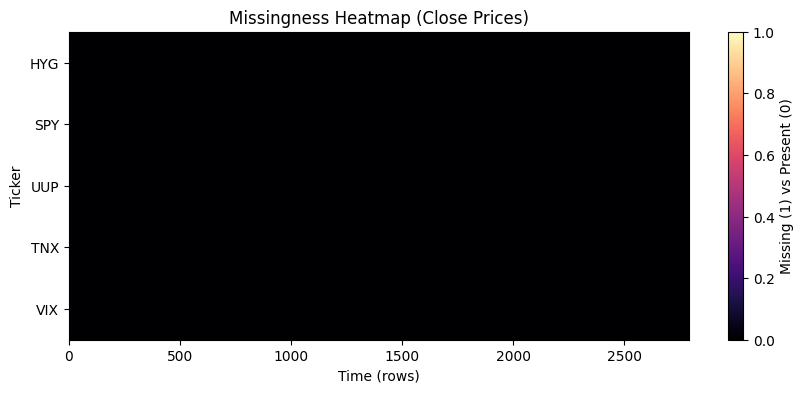

In [5]:
missing_matrix = close.isna()
plt.figure(figsize=(10, 4))
plt.imshow(missing_matrix.T, aspect="auto", interpolation="nearest", cmap="magma", vmin=0, vmax=1)
plt.colorbar(label="Missing (1) vs Present (0)")
plt.yticks(range(len(close.columns)), close.columns)
plt.title("Missingness Heatmap (Close Prices)")
plt.xlabel("Time (rows)")
plt.ylabel("Ticker")
plt.show()

if missing_matrix.sum().sum() == 0:
    print("Note: No missing values in raw Close prices. A solid block is expected. Missingness appears in engineered features below.")


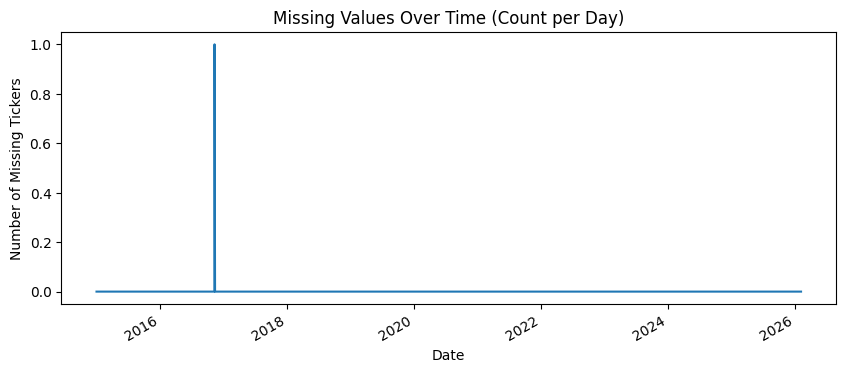

In [6]:
missing_over_time = close.isna().sum(axis=1)
plt.figure(figsize=(10, 4))
missing_over_time.plot()
plt.title("Missing Values Over Time (Count per Day)")
plt.ylabel("Number of Missing Tickers")
plt.xlabel("Date")
plt.show()


What to look for:

- Is missingness concentrated in specific tickers (e.g., VIX/TNX), or across all series?
- Do the spikes align with market holidays or vendor outages?
- Are there long gaps that would remove entire regimes if you drop rows?

**IMPORTANT: Missingness is rare and isolated at the raw close‑price level. Most missingness you see later will come from engineered features (rolling windows, return calculations), not from Yahoo data itself.**

---

## Part 2 - Handling Missing Data

Use this decision flow before choosing a method:

1. Decide how much data you can afford to drop.  
2. Decide whether the variable is a level (price, yield) or a return.  
3. Decide whether regimes are stable or shifting.

Then pick the imputation method below.


### Feature Engineering (Used in the Model Later)

We construct features using only information available at time t or earlier. No future data is used.

SPY-based features (inputs derived from SPY at time t):
- r_1d: daily return at time t
- r_5d: rolling 5-day cumulative return
- vol_20d: rolling 20-day standard deviation of daily returns
- ma_gap: (Close - MA_20) / MA_20
- volume_change: percentage change in daily volume

Volatility and macro proxies (inputs from other tickers at time t):
- vix_level: ^VIX close level
- vix_change: 1-day change in ^VIX
- tnx_level: ^TNX close level
- tnx_change: 1-day change in ^TNX

Credit and FX proxies (inputs from other tickers at time t):
- hyg_return_1d
- uup_return_1d


In [7]:
spy_close = close["SPY"]
spy_volume = volume["SPY"]

r_1d = spy_close.pct_change()
r_5d = (1 + r_1d).rolling(5).apply(np.prod, raw=True) - 1
vol_20d = r_1d.rolling(20).std()
ma_20 = spy_close.rolling(20).mean()
ma_gap = (spy_close - ma_20) / ma_20
volume_change = spy_volume.pct_change()

vix_level = close["VIX"]
vix_change = vix_level.diff()

tnx_level = close["TNX"]
tnx_change = tnx_level.diff()

features = pd.DataFrame({
    "r_1d": r_1d,
    "r_5d": r_5d,
    "vol_20d": vol_20d,
    "ma_gap": ma_gap,
    "volume_change": volume_change,
    "vix_level": vix_level,
    "vix_change": vix_change,
    "tnx_level": tnx_level,
    "tnx_change": tnx_change,
}, index=close.index)

# Credit and FX proxies (guarded if a series is missing)
if "HYG" in close.columns:
    features["hyg_return_1d"] = close["HYG"].pct_change()

if "UUP" in close.columns:
    features["uup_return_1d"] = close["UUP"].pct_change()

features.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d
Date,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,17.790001,NaN,2.123,NaN,NaN,NaN
2015-01-05,-0.018060,NaN,NaN,NaN,0.396545,19.920000,2.129999,2.039,-0.084,-0.009263,0.002066
2015-01-06,-0.009419,NaN,NaN,NaN,0.232967,21.120001,1.200001,1.963,-0.076,-0.003830,0.002062
2015-01-07,0.012461,NaN,NaN,NaN,-0.400689,19.309999,-1.810001,1.954,-0.009,0.006220,0.003704
2015-01-08,0.017745,NaN,NaN,NaN,0.174485,17.010000,-2.299999,2.016,0.062,0.007530,0.004100


### Missingness in Engineered Features


In [8]:
features.isna().mean().mul(100).round(2).sort_values(ascending=False)


vol_20d          0.72
ma_gap           0.68
r_5d             0.18
tnx_change       0.11
r_1d             0.04
vix_change       0.04
volume_change    0.04
hyg_return_1d    0.04
tnx_level        0.04
uup_return_1d    0.04
vix_level        0.00
dtype: float64

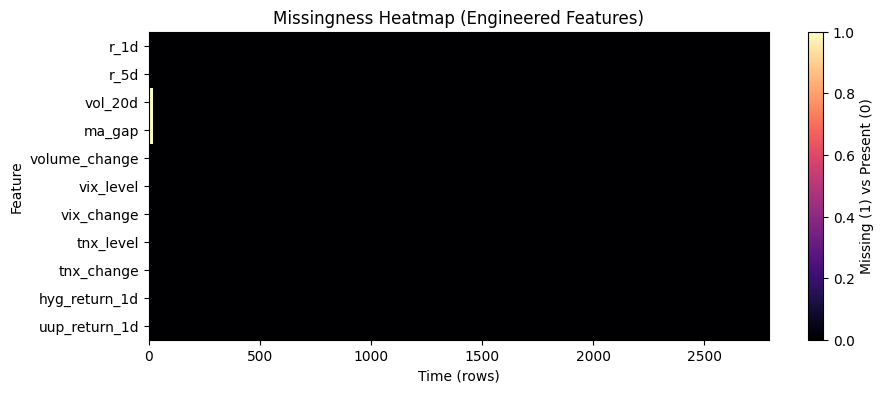

In [9]:
plt.figure(figsize=(10, 4))
plt.imshow(features.isna().T, aspect="auto", interpolation="nearest", cmap="magma", vmin=0, vmax=1)
plt.colorbar(label="Missing (1) vs Present (0)")
plt.yticks(range(len(features.columns)), features.columns)
plt.title("Missingness Heatmap (Engineered Features)")
plt.xlabel("Time (rows)")
plt.ylabel("Feature")
plt.show()


### Method 1 - Dropping Rows or Columns

Pros: simple and transparent.  
Cons: can remove large periods of data or bias toward liquid regimes.

Use when: missingness is rare and you can afford fewer rows.  
Avoid when: you would remove an entire market regime.

Example:


In [10]:
rows_before = len(features)
features_drop_rows = features.dropna()
rows_after = len(features_drop_rows)

cols_before = features.shape[1]
features_drop_cols = features.dropna(axis=1, thresh=int(0.95 * len(features)))
cols_after = features_drop_cols.shape[1]

pd.DataFrame({
    "Rows before": [rows_before],
    "Rows after dropna": [rows_after],
    "Cols before": [cols_before],
    "Cols after dropna thresh": [cols_after]
})


,Rows before,Rows after dropna,Cols before,Cols after dropna thresh
0,2791,2769,11,11


### Method 2 - Mean / Median Imputation

Pros: fast and stable.  
Cons: can wash out signals in volatile regimes.

Use when: the feature distribution is stable and you need a baseline.  
Avoid when: the feature is skewed or regime-driven (use median instead of mean).

Example (median):


In [11]:
median_imputer = SimpleImputer(strategy="median")
features_median = pd.DataFrame(
    median_imputer.fit_transform(features),
    index=features.index,
    columns=features.columns
)

features_median.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d
Date,,,,,,,,,,,
2015-01-02,0.000597,0.004027,0.007701,0.00826,-0.004973,17.790001,-0.100000,2.123,0.000,0.000117,0.000345
2015-01-05,-0.018060,0.004027,0.007701,0.00826,0.396545,19.920000,2.129999,2.039,-0.084,-0.009263,0.002066
2015-01-06,-0.009419,0.004027,0.007701,0.00826,0.232967,21.120001,1.200001,1.963,-0.076,-0.003830,0.002062
2015-01-07,0.012461,0.004027,0.007701,0.00826,-0.400689,19.309999,-1.810001,1.954,-0.009,0.006220,0.003704
2015-01-08,0.017745,0.004027,0.007701,0.00826,0.174485,17.010000,-2.299999,2.016,0.062,0.007530,0.004100


### Method 3 - Forward Fill and Backward Fill

Pros: respects time order and is common in finance.  
Cons: if used incorrectly across train/test boundaries, it can leak future info.

Use when: the series is a level (not a return) and gaps are short.  
Avoid when: gaps are long or you are filling across the split.

We must apply forward/back fill within the training period only when modelling.


<p align="center">
<img src="https://towardsdatascience.com/wp-content/uploads/2022/02/0YwUB4dPvVs2GQHLV.png" width="400">
</p>

<p align="center">
<img src="https://towardsdatascience.com/wp-content/uploads/2022/02/0oiDtJRmjPO7mRpFS.png" width="400">
</p>

*Reference:* https://towardsdatascience.com/how-to-fill-missing-data-with-pandas-8cb875362a0d/

In [12]:
features_ffill = features.ffill()
features_bfill = features.bfill()

features_ffill.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d
Date,,,,,,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,17.790001,NaN,2.123,NaN,NaN,NaN
2015-01-05,-0.018060,NaN,NaN,NaN,0.396545,19.920000,2.129999,2.039,-0.084,-0.009263,0.002066
2015-01-06,-0.009419,NaN,NaN,NaN,0.232967,21.120001,1.200001,1.963,-0.076,-0.003830,0.002062
2015-01-07,0.012461,NaN,NaN,NaN,-0.400689,19.309999,-1.810001,1.954,-0.009,0.006220,0.003704
2015-01-08,0.017745,NaN,NaN,NaN,0.174485,17.010000,-2.299999,2.016,0.062,0.007530,0.004100


Why you’re still seeing NaNs?

- Forward fill only fills from prior values, so the first rows stay NaN because there’s nothing before them.
- Rolling features create structural NaNs at the start (e.g., vol_20d has NaNs for the first 19 rows).
- If a column has a long missing stretch or starts missing, forward fill can’t fix it.

### Method 4 - KNN Imputation

**Pros:** can preserve relationships between variables.  
**Cons:** slower and can blur regime shifts.

Use when: features are correlated and regimes are stable.  
Avoid when: behavior changes quickly (crises, policy shifts).

Example:


<p align="center">
<img src="https://substackcdn.com/image/fetch/$s_!DRnG!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fe517b2b2-aa4d-4ad2-9f71-ad068c4db993_3115x1744.png" width="800">
</p>

*Reference:* https://blog.dailydoseofds.com/p/3-types-of-missing-values

In [13]:
knn_imputer = KNNImputer(n_neighbors=5)
features_knn = pd.DataFrame(
    knn_imputer.fit_transform(features),
    index=features.index,
    columns=features.columns
)

features_knn.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d
Date,,,,,,,,,,,
2015-01-02,-0.002762,-0.007625,0.009102,-0.004392,0.344078,17.790001,0.464000,2.123,-0.0324,-0.002914,-0.001091
2015-01-05,-0.018060,-0.013949,0.008427,-0.021057,0.396545,19.920000,2.129999,2.039,-0.0840,-0.009263,0.002066
2015-01-06,-0.009419,-0.013030,0.012109,0.001134,0.232967,21.120001,1.200001,1.963,-0.0760,-0.003830,0.002062
2015-01-07,0.012461,0.011967,0.011639,0.005572,-0.400689,19.309999,-1.810001,1.954,-0.0090,0.006220,0.003704
2015-01-08,0.017745,0.007403,0.010158,0.002963,0.174485,17.010000,-2.299999,2.016,0.0620,0.007530,0.004100


### Method 5 - Iterative / Model-Based Imputation (Advanced)

Instead of filling a missing value with a simple statistic (mean/median), this method **builds a small predictive model** for each column with missing values.  
It uses the other columns to estimate the missing entries, then repeats the process a few times to refine the estimates.

**Pros**
- Can be more accurate when variables move together (e.g., SPY, VIX, and TNX).
- Preserves cross‑feature relationships better than simple imputation.

**Cons**
- Slower and more complex to explain.
- Can **inject model bias** if the relationships are unstable or regime‑dependent.
- Harder to audit because the imputed value is a model output, not a direct statistic.

**Use when**
- Features are **strongly related** and reasonably stable.
- You can **validate** the imputed values and check model error.



In [14]:
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer

iter_imputer = IterativeImputer(random_state=42, max_iter=10)
features_iter = pd.DataFrame(
    iter_imputer.fit_transform(features),
    index=features.index,
    columns=features.columns
)

features_iter.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d
Date,,,,,,,,,,,
2015-01-02,0.000381,0.003028,0.008769,0.006075,0.055110,17.790001,-0.050198,2.123,-0.000417,-0.000066,0.000088
2015-01-05,-0.018060,-0.002281,0.009620,-0.004102,0.396545,19.920000,2.129999,2.039,-0.084000,-0.009263,0.002066
2015-01-06,-0.009419,-0.001092,0.010886,-0.002927,0.232967,21.120001,1.200001,1.963,-0.076000,-0.003830,0.002062
2015-01-07,0.012461,0.004847,0.010630,0.006907,-0.400689,19.309999,-1.810001,1.954,-0.009000,0.006220,0.003704
2015-01-08,0.017745,0.006272,0.008919,0.013186,0.174485,17.010000,-2.299999,2.016,0.062000,0.007530,0.004100


### Method 6 - Missingness Indicators (`was_missing` Flags)

Why this matters: in finance, missingness itself can carry signal (illiquidity, reporting delays).

Step: create binary flags and keep them alongside the imputed features.
We will also use `add_indicator=True` in the model pipeline to do this automatically.


In [15]:
missing_flags = features.isna().astype(int).add_prefix("was_missing_")
features_with_flags = pd.concat([features_median, missing_flags], axis=1)

features_with_flags.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,...,was_missing_r_5d,was_missing_vol_20d,was_missing_ma_gap,was_missing_volume_change,was_missing_vix_level,was_missing_vix_change,was_missing_tnx_level,was_missing_tnx_change,was_missing_hyg_return_1d,was_missing_uup_return_1d
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.000597,0.004027,0.007701,0.00826,-0.004973,17.790001,-0.100000,2.123,0.000,0.000117,...,1,1,1,1,0,1,0,1,1,1
2015-01-05,-0.018060,0.004027,0.007701,0.00826,0.396545,19.920000,2.129999,2.039,-0.084,-0.009263,...,1,1,1,0,0,0,0,0,0,0
2015-01-06,-0.009419,0.004027,0.007701,0.00826,0.232967,21.120001,1.200001,1.963,-0.076,-0.003830,...,1,1,1,0,0,0,0,0,0,0
2015-01-07,0.012461,0.004027,0.007701,0.00826,-0.400689,19.309999,-1.810001,1.954,-0.009,0.006220,...,1,1,1,0,0,0,0,0,0,0
2015-01-08,0.017745,0.004027,0.007701,0.00826,0.174485,17.010000,-2.299999,2.016,0.062,0.007530,...,1,1,1,0,0,0,0,0,0,0


---

## Part 3 - Baseline Regression Model

We want to build a simple, interpretable model to predict next-day SPY returns.


### Regression Target

The regression task is:

Predict next-day SPY return using information available at time t.

Target definition:

$$
y_t = \frac{\mathrm{SPYClose}_{t+1}}{\mathrm{SPYClose}_t} - 1
$$

Step 1: Create the next-day return using $\mathrm{SPYClose}_{t+1}$ and $\mathrm{SPYClose}_t$.

Step 2: Align the target with features at time t.  
Step 3: Drop the last row (no t+1) and early rows from rolling windows.

Only SPY is predicted. The other tickers contribute inputs (features) at time t.

All features must be constructed using data available at time t or earlier.  
No future information is allowed.


In [16]:
target = (spy_close.shift(-1) / spy_close) - 1

data = features.copy()
data["target"] = target

# Drop the last row (no t+1 price available)
data = data.dropna(subset=["target"])

# Remove early rows where rolling features do not exist (20-day lookback)
data = data.iloc[20:]

data.head()


,r_1d,r_5d,vol_20d,ma_gap,volume_change,vix_level,vix_change,tnx_level,tnx_change,hyg_return_1d,uup_return_1d,target
Date,,,,,,,,,,,,
2015-02-02,0.012384,-0.017182,0.011050,-0.002406,-0.175101,19.430000,-1.539999,1.673,-0.002,-0.000222,-0.001990,0.014461
2015-02-03,0.014461,0.010358,0.010766,0.011241,-0.238458,17.330000,-2.100000,1.780,0.107,0.005653,-0.011563,-0.003808
2015-02-04,-0.003808,0.019586,0.010557,0.006337,0.081262,18.330000,1.000000,1.797,0.017,-0.004189,0.006051,0.010095
2015-02-05,0.010095,0.020447,0.010435,0.015542,-0.270675,16.850000,-1.480000,1.815,0.018,0.005867,-0.007217,-0.002765
2015-02-06,-0.002765,0.030584,0.009682,0.012821,0.282980,17.290001,0.440001,1.938,0.123,0.000770,0.012116,-0.004476


### Time-Based Train/Test Split

Step 1: Separate features (X) and target (y).  
Step 2: Split by time (80% train, 20% test).  
No random shuffling.


In [17]:
X = data.drop(columns=["target"])
y = data["target"]

split_idx = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

X_train.index.min(), X_train.index.max(), X_test.index.min(), X_test.index.max()


(Timestamp('2015-02-02 00:00:00'),
 Timestamp('2023-11-17 00:00:00'),
 Timestamp('2023-11-20 00:00:00'),
 Timestamp('2026-02-05 00:00:00'))

### Model Pipeline

Step 1: Build a Pipeline with Imputer -> StandardScaler -> Model.  
Step 2: Fit on the training set only.  
Step 3: Evaluate on the test set.

Here, X contains the engineered features from SPY, VIX, TNX, HYG, and UUP.  
y is the next-day SPY return.


### Model Comparison (Baseline + Stronger Non-Linear)

Model 1: LinearRegression: simple, fast, and interpretable.  
Model 2: Ridge: same structure but regularised for stability.  
Model 3: HistGradientBoosting: captures non-linear interactions in a controlled way.  
Model 4: RandomForest: second non-linear reference for comparison.


In [18]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(
        max_depth=3,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    ),
    "RandomForest": RandomForestRegressor(
        n_estimators=200,
        max_depth=5,
        random_state=42
    )
}

results = []

for name, model in models.items():
    pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    })

results_df = pd.DataFrame(results).sort_values(by="RMSE")
results_df


,Model,MAE,RMSE,R2
3,RandomForest,0.006453,0.009791,0.043524
1,Ridge,0.006567,0.010048,-0.007331
0,LinearRegression,0.006567,0.010048,-0.007364
2,HistGradientBoosting,0.006652,0.010389,-0.076852


### Why the Models Can Look Weak (Reality Check)

- Next-day equity returns are close to noise; true signal is small.  
- Most inputs here are slow-moving (rolling returns, vol, yields), so they do not react sharply day-to-day.  
- Even non-linear models struggle when the input features contain limited short‑horizon signal.  
- If multiple models all predict near zero, it usually means the problem is low‑signal, not that the model is broken.  
- This is normal in daily return prediction and is why evaluation focuses on error size, stability, and risk impact.


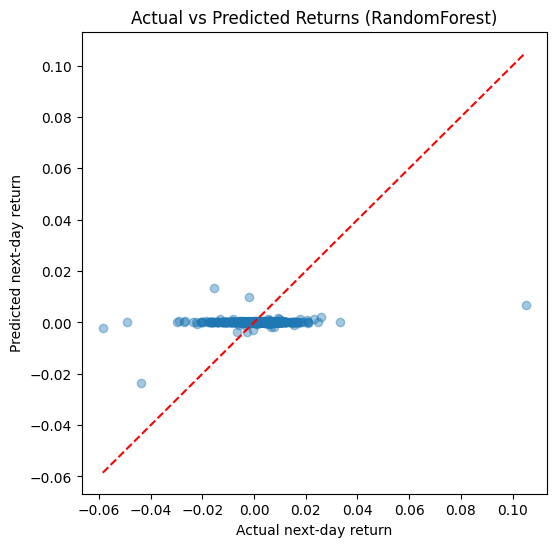

In [19]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

best_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler()),
    ("model", best_model)
])

best_pipe.fit(X_train, y_train)
preds = best_pipe.predict(X_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, preds, alpha=0.4)
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--")
plt.title(f"Actual vs Predicted Returns ({best_model_name})")
plt.xlabel("Actual next-day return")
plt.ylabel("Predicted next-day return")
plt.show()


### Interpreting the Scatter Plot

- Each dot is one day: x = actual SPY next‑day return, y = model prediction.
- The red dashed line is perfect prediction. The closer the dots are to that line, the better.
- A tight horizontal band around 0 means the model is mostly predicting small, near‑zero returns.
- This tells us the model is not capturing day‑to‑day swings, which is common for next‑day returns.


---

## Part 4 - Finance Interpretation and Pitfalls

Data leakage risks (must avoid):
- Split by time before any imputation or scaling.
- Never forward-fill across the train/test boundary.
- Use only information available at time t when building features.

How imputation can distort signals:
- Imputation can smooth real spikes during volatile regimes.
- Check error by regime: compare pre-2020 vs 2020-2022, or use a rolling 12-month window.

### What to do next?
- Improve features before chasing complexity (lags, regime indicators, macro deltas).
- Decide the business use-case first (risk control, timing, or hedging), then pick metrics.
- Test longer horizons (e.g., 5-day returns) where signal can be stronger.
- Use **walk-forward validation** to check stability through time

Instead of one static train/test split, you **move the test window forward through time** and re‑train each time.  
This checks whether the model stays useful as market conditions change.



<p align="center">
<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/0*MePEKgLfIGULgrdi" width="600">
</p>

*Reference:* https://medium.com/@ahmedfahad04/understanding-walk-forward-validation-in-time-series-analysis-a-practical-guide-ea3814015abf

In [20]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

def walk_forward_validation(X, y, model, initial_train_frac=0.6, test_size=126, step_size=126):
    n = len(X)
    train_end = int(n * initial_train_frac)
    results = []

    while train_end + test_size <= n:
        X_train = X.iloc[:train_end]
        y_train = y.iloc[:train_end]
        X_test = X.iloc[train_end:train_end + test_size]
        y_test = y.iloc[train_end:train_end + test_size]

        pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
            ("scaler", StandardScaler()),
            ("model", model)
        ])

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)

        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        r2 = r2_score(y_test, preds)

        results.append({
            "Test Start": X_test.index.min().date(),
            "Test End": X_test.index.max().date(),
            "MAE": mae,
            "RMSE": rmse,
            "R2": r2
        })

        train_end += step_size

    return pd.DataFrame(results)

wf_results = walk_forward_validation(X, y, best_model)
wf_results


,Test Start,Test End,MAE,RMSE,R2
0,2021-09-08,2022-03-08,0.008667,0.011008,-0.005769
1,2022-03-09,2022-09-07,0.011838,0.015208,0.015674
2,2022-09-08,2023-03-09,0.011351,0.014616,-0.060696
3,2023-03-10,2023-09-08,0.006347,0.008162,-0.159226
4,2023-09-11,2024-03-11,0.005918,0.007683,-0.011315
5,2024-03-12,2024-09-10,0.006201,0.008336,0.008556
6,2024-09-11,2025-03-13,0.006433,0.008675,-0.004784
7,2025-03-14,2025-09-12,0.008175,0.014393,0.074932


Observations:

- If MAE/RMSE are similar across windows, the model is stable.
- Large swings suggest the model is regime-sensitive and needs stronger features.
- Consistently weak scores across windows indicate a low-signal problem at this horizon.


In [21]:
wf_results[["MAE", "RMSE", "R2"]].mean().to_frame("Average")

,Average
MAE,0.008116
RMSE,0.011010
R2,-0.017828
